## Geospatial data exploration using matplotlib and seaborn

This is a demonstration of multiple subplots of impervious surface proportion per grid cell using matplotlib. This is a critical step prior to classifying the land-use type of each cell in the study area grid because it reveals the distribution of pixels within each cell. Each pixel approximately represents the impervious surface proportion within 30x30 meters in the real world. 

The objective of this script is to plot the cumulative frequency impervious surface pixels within each grid cell of the study area. I'll be playing around with matplotlib and seaborn to see which is easier to use. 

Other references can be found in these sites:

- [Pyplot Tutorial](http://matplotlib.org/users/pyplot_tutorial.html)
- [Useful tip from the late creator of matplotlib, John Hunter](https://gist.github.com/LeoHuckvale/89683dc242f871c8e69b)
- [Dynamically add/create subplots in matplotlib](http://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib)
- [Dynamically add subplots in matplotlib with more than one column](http://stackoverflow.com/questions/31575399/dynamically-add-subplots-in-matplotlib-with-more-than-one-column)

The reference for multiple plots in a grid: 
- [How to use matplotlib tight layout with figure](http://stackoverflow.com/questions/9603230/how-to-use-matplotlib-tight-layout-with-figure)


In [229]:
import rasterio as rio
import time as tm
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterstats as rs

import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
import warnings
from sklearn.preprocessing import normalize, MinMaxScaler

warnings.filterwarnings("ignore")

The code block below visualizes the study area grid and the resampled worldview2 classified image. The [rasterio](https://mapbox.github.io/rasterio/intro.html) library allow userst to handle satellite images while [geopandas](http://geopandas.org/) and [pandas](http://pandas.pydata.org/) are used to handle the geographical vector files (.shp) and their attributes in the form of DataFrames.

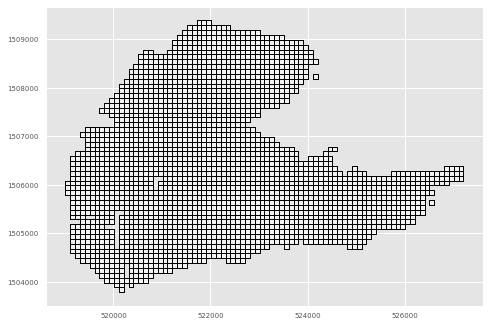

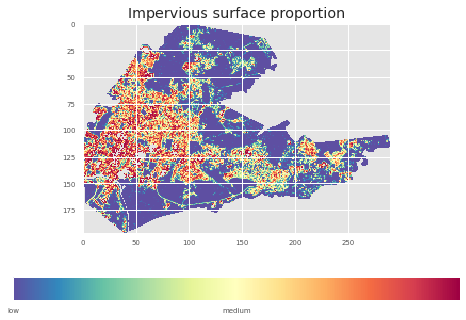

In [230]:
"""
http://stackoverflow.com/questions/15408371/cumulative-distribution-plots-python
http://matplotlib.org/examples/statistics/histogram_demo_cumulative.html

Cumulative frequency plots of impervious surfaces
per training grid cell.
"""

img_dir = 'resampled.tif'  # data to explore
grid_dir = 'grid100.tif'  # grid labels
sa_grid_dir = 'study_area\\study_area.shp'  # study area grid

img = rio.open(img_dir)
lgrid = rio.open(grid_dir)
pgrid = gpd.read_file(sa_grid_dir)

data = img.read(1)
grid = lgrid.read(1)

data[data>=1] = np.nan

# plot study area grid
pgrid.plot(color='white')
plt.show()

# plot raster image of impervious surface proportions
fig, ax = plt.subplots()
pax = ax.imshow(data, interpolation='nearest', cmap='Spectral_r' )
ax.set_title('Impervious surface proportion')
cbar = fig.colorbar(pax, ticks=[0., 0.5, 1.0], orientation='horizontal')
cbar.ax.set_xticklabels(['low', 'medium', 'high'])

plt.show()

Data modelled as DataFrames of pandas and geopandas can be filtered and sorted similarly the way it is done in Excel (or SQL, though I am not a SQL user I am aware of the language and its uses). The current dataset has many features (individual vector features with geographical and thematic attributes) that I am not interested in so I have to filter those out.

The training cells have pre-defined (by me using GIS) values in their (int) lu_code and (string) lu_type columns that can be filtered using logical operations.

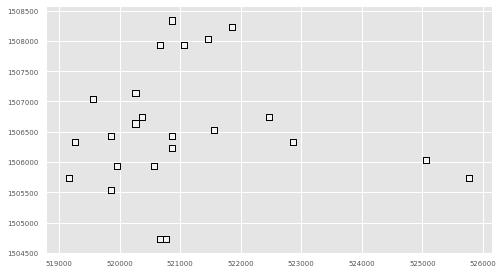

In [231]:
# cells with lu_codes greater than 0 are
# the training cells
tr_cell_i = pgrid[pgrid['lu_code']!= 0].index 

# isolate training grid cells and count num
# of cells with num of pixels > 0
valid_cells = {}
for i, cell_i in enumerate(tr_cell_i):

    data[data>=1] = np.nan
    cell_pix = data[grid==cell_i]
    cell_pix = cell_pix[~np.isnan(cell_pix)] # filter out nodata pixels
    
    # ignore cells with pixel values of nan
    if len(cell_pix) > 0:
        valid_cells[cell_i] = cell_pix
        
# plot the training cells
pgrid.loc[valid_cells].plot(color='white')
plt.show()

Given that we know the number of cells we want to visualize, I can use that number as a definition for the side of a square to create an instance of a matplotlib figure.

In [236]:
# create matplotlib figure using total num
# of valid cells
a = int(len(valid_cells)**.5) + 1
b = a
fig = plt.figure(figsize=(a*2, b*2))

To dynamically adjust the settings of each element of a figure and subplot, the [matplotlib.rc](http://matplotlib.org/api/matplotlib_configuration_api.html#matplotlib.rc) function can be used. This function modifies the [matplotlibrc file](http://matplotlib.org/users/customizing.html) which contains settings for pre-defined plot styling.

In [237]:
# dynamically adjust plot style
# here i am interested in adjusting the
# label size of each axis tick
xticks = {'labelsize' : 'x-small'}
yticks = {'labelsize' : 'x-small'}

matplotlib.rc('xtick', **xticks)
matplotlib.rc('ytick', **yticks)

plt.xlabel('Impervious surface proportion', fontsize=10)
plt.ylabel('Cumulative frequency',  fontsize=10)

This is the 'meat' of the script. To explore the statistical information per training cell I plot the theoretical and empirical cumulative frequency of impervious surface pixels within each cell.

The logic for dynamic subplotting was partially modified from the algorithm presented [here](https://kratsg.quora.com/Dynamic-Subplots-NumPy-and-PyLab).

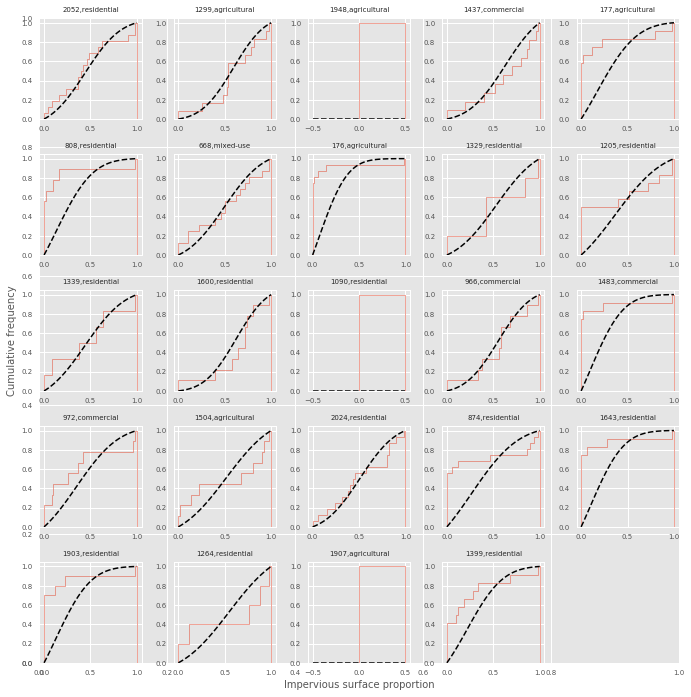

In [238]:
for i, cell_i in enumerate(valid_cells):
    
    # collect land-use type
    lu = pgrid.loc[cell_i, 'lu_type']
    
    # add a subplot per figure
    ax = fig.add_subplot(a, b, i+1)
    
    # scale cell pixels from (0,1)
    scaler = MinMaxScaler()
    cell_pix_norm = scaler.fit_transform(valid_cells[cell_i])

    n, bins, patches = plt.hist(cell_pix_norm, bins=50, histtype='step', normed=1,
                           cumulative=True, label='Empirical')

    # cumulative frequency plotting parameters
    mu = cell_pix_norm.mean()
    sigma = cell_pix_norm.std()

    # plot the theoretical cumulative frequency
    y = mlab.normpdf(bins, mu, sigma).cumsum()
    y /= y[-1]
    y[np.isnan(y)] = 0.
    y_norm = scaler.fit_transform(y)

    ax.plot(bins, y_norm, 'k--', linewidth=1.5, label='Theoretical')
    ax.set_title(str(cell_i) + ', ' + lu, size='x-small')

fig.set_tight_layout(True)
fig.tight_layout()

fig.savefig('plot.png', dpi=250)
plt.show()

We can improve this further by grouping the cells by land-use type using Panda's groupby function for a DataFrame. 

In [239]:
fig1 = plt.figure()
for i, tup in enumerate(pgrid.loc[valid_cells].groupby(by='lu_type')):
    print tup[1]['kurtosis']
  

1299   -3.000000
1948   -3.000000
177    -3.000000
176    -3.000000
1504   -3.000000
1907    2.055884
Name: kurtosis, dtype: float64
1437    0.223337
966    -0.851142
1483    3.914542
972     0.393139
Name: kurtosis, dtype: float64
668    0.372231
Name: kurtosis, dtype: float64
2052   -0.969251
808    -1.685443
1329    0.431711
1205   -0.638255
1339   -0.693279
1600    1.472095
1090    0.552092
2024   -0.664667
874    -0.941639
1643   -0.439197
1903    0.298740
1264    2.234677
1399   -0.482380
Name: kurtosis, dtype: float64
